In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.models import load_model
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tensorflow.compat'

In [2]:
x_test=np.load('../Data/Q3_x_text.npy')
y_test=np.load('../Data/Q3_y_test.npy')
print(x_test.shape, y_test.shape)

(49108, 2) (49108,)


In [3]:
model=load_model('../NN_model/96.6_Q3.h5', compile=False)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 HiddenLayer1 (Dense)        (None, 8)                 24        
                                                                 
 HiddenLayer2 (Dense)        (None, 4)                 36        
                                                                 
 OuputLayer (Dense)          (None, 1)                 5         
                                                                 
Total params: 65 (260.00 Byte)
Trainable params: 65 (260.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [4]:
count=0
count1=0
y_pred=model.predict(x_test)
for i in range(y_pred.shape[0]):
    if y_test[i]==0:
        count+=1
        if y_pred[i]<0.5:
            count1+=1
print(count,count1)
print(count1/count)
count=0
count1=0
y_pred=model.predict(x_test)
for i in range(y_pred.shape[0]):
    if y_test[i]==1:
        count+=1
        if y_pred[i]>0.5:
            count1+=1
print(count,count1)
print(count1/count)

1535/1535 [==============================] - 1s 731us/step
24560 23919
0.9739006514657981
1535/1535 [==============================] - 1s 665us/step
24548 23471
0.9561267720384553


## HLS4ML

In [5]:
import os
import hls4ml
import plotting
from hls4ml.model import profiling

In [6]:
# os.environ['PATH']+= os.pathsep + '/opt/Xilinx/Vivado/2022.1/bin'
os.environ['PATH']+= os.pathsep + '/opt/Xilinx/Vivado/2018.3/bin'

In [7]:
config = hls4ml.utils.config_from_keras_model(model, granularity='name')
print("-----------------------------------")
plotting.print_dict(config)
print("-----------------------------------")

Interpreting Sequential
Topology:
Layer name: input_2, layer type: InputLayer, input shapes: [[None, 2]], output shape: [None, 2]
Layer name: HiddenLayer1, layer type: Dense, input shapes: [[None, 2]], output shape: [None, 8]
Layer name: HiddenLayer2, layer type: Dense, input shapes: [[None, 8]], output shape: [None, 4]
Layer name: OuputLayer, layer type: Dense, input shapes: [[None, 4]], output shape: [None, 1]
-----------------------------------
Model
  Precision:         fixed<16,6>
  ReuseFactor:       1
  Strategy:          Latency
  BramFactor:        1000000000
  TraceOutput:       False
LayerName
  input_2
    Trace:           False
    Precision
      result:        fixed<16,6>
  HiddenLayer1
    Trace:           False
    Precision
      result:        fixed<16,6>
      weight:        fixed<16,6>
      bias:          fixed<16,6>
  HiddenLayer1_relu
    Trace:           False
    Precision
      result:        fixed<16,6>
  HiddenLayer2
    Trace:           False
    Precision

In [8]:
config={'Model': {'Precision': 'fixed<18,6>', 'ReuseFactor': 1, 'Strategy': 'Latency', 'BramFactor': 1000000000, 'TraceOutput': False}, 'LayerName': {'input_2': {'Trace': False, 'Precision': {'result': 'fixed<18,6>'}}, 'HiddenLayer1': {'Trace': False, 'Precision': {'result': 'fixed<18,6>', 'weight': 'fixed<18,6>', 'bias': 'fixed<18,6>'}}, 'HiddenLayer1_relu': {'Trace': False, 'Precision': {'result': 'fixed<18,6>'}}, 'HiddenLayer2': {'Trace': False, 'Precision': {'result': 'fixed<18,6>', 'weight': 'fixed<18,6>', 'bias': 'fixed<18,6>'}}, 'HiddenLayer2_relu': {'Trace': False, 'Precision': {'result': 'fixed<18,6>'}}, 'OuputLayer': {'Trace': False, 'Precision': {'result': 'fixed<18,6>', 'weight': 'fixed<18,6>', 'bias': 'fixed<18,6>'}}, 'OuputLayer_sigmoid': {'Trace': False, 'Precision': {'result': 'fixed<18,6>'}}}}

In [9]:
# config['LayerName']['input_2']['Precision']['result']='ap_fixed<32,12>'
plotting.print_dict(config)

Model
  Precision:         fixed<18,6>
  ReuseFactor:       1
  Strategy:          Latency
  BramFactor:        1000000000
  TraceOutput:       False
LayerName
  input_2
    Trace:           False
    Precision
      result:        fixed<18,6>
  HiddenLayer1
    Trace:           False
    Precision
      result:        fixed<18,6>
      weight:        fixed<18,6>
      bias:          fixed<18,6>
  HiddenLayer1_relu
    Trace:           False
    Precision
      result:        fixed<18,6>
  HiddenLayer2
    Trace:           False
    Precision
      result:        fixed<18,6>
      weight:        fixed<18,6>
      bias:          fixed<18,6>
  HiddenLayer2_relu
    Trace:           False
    Precision
      result:        fixed<18,6>
  OuputLayer
    Trace:           False
    Precision
      result:        fixed<18,6>
      weight:        fixed<18,6>
      bias:          fixed<18,6>
  OuputLayer_sigmoid
    Trace:           False
    Precision
      result:        fixed<18,6>


In [10]:
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='../Q3_new/lbnl',part='xc7vx485tffg1761-2',input_data_tb='../Data/Q3_x_text.npy',output_data_tb='../Data/Q3_y_test.npy',
)

Interpreting Sequential
Topology:
Layer name: input_2, layer type: InputLayer, input shapes: [[None, 2]], output shape: [None, 2]
Layer name: HiddenLayer1, layer type: Dense, input shapes: [[None, 2]], output shape: [None, 8]
Layer name: HiddenLayer2, layer type: Dense, input shapes: [[None, 8]], output shape: [None, 4]
Layer name: OuputLayer, layer type: Dense, input shapes: [[None, 4]], output shape: [None, 1]
Creating HLS model


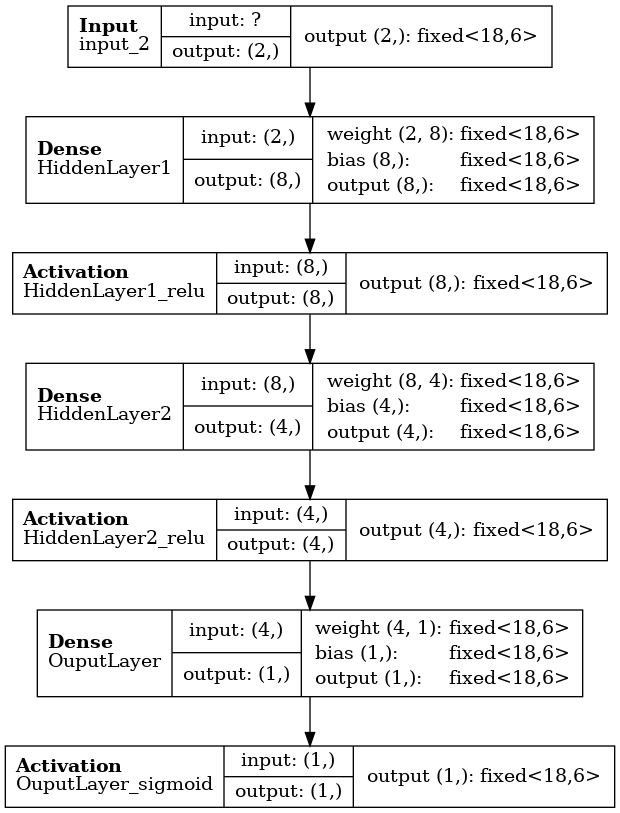

In [11]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_layer_names=True, show_precision=True, to_file=None)

In [12]:
hls_model.compile()
y_hls=hls_model.predict(np.ascontiguousarray(x_test))

Writing HLS project


/home/neelvora/miniconda3/envs/readout/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done


In [13]:
count=0
count1=0
for i in range(y_hls.shape[0]):
    if y_test[i]==0:
        count+=1
        if y_hls[i]<0.5:
            count1+=1
print(count1/count)

count=0
count1=0
for i in range(y_hls.shape[0]):
    if y_test[i]==1:
        count+=1
        if y_hls[i]>0.5:
            count1+=1
print(count1/count)
# np.set_printoptions(threshold=np.inf)
print(y_hls.shape,y_test.shape)

0.9721091205211726
0.9564934006843735
(49108, 1) (49108,)


In [14]:
hls_model.build(csim='True', validation='True', cosim='True')


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2018.3 (64-bit)
  **** SW Build 2405991 on Thu Dec  6 23:36:41 MST 2018
  **** IP Build 2404404 on Fri Dec  7 01:43:56 MST 2018
    ** Copyright 1986-2018 Xilinx, Inc. All Rights Reserved.

source /opt/Xilinx/Vivado/2018.3/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/opt/Xilinx/Vivado/2018.3/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'neelvora' on host 'new-begcbp-desktop' (Linux_x86_64 version 5.15.0-89-generic) on Thu Jan 11 15:18:50 PST 2024
INFO: [HLS 200-10] On os Ubuntu 22.04.3 LTS
INFO: [HLS 200-10] In directory '/home/neelvora/Projects/Quantum/Q3_new/lbnl'
INFO: [HLS 200-10] Creating and opening project '/home/neelvora/Projects/Quantum/Q3_new/lbnl/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject.cpp' to the project
INFO: [HLS 200-10] Adding test bench file 'myproject_test.cpp' to the project
INFO: [HLS 200-10] Adding test bench file 'firmware/we

{'CSimResults': [['0.0146484'],
  ['0.996094'],
  ['0.00195313'],
  ['0.995117'],
  ['0.137695'],
  ['0.00585938'],
  ['0.000976563'],
  ['0.996094'],
  ['0'],
  ['0.514648'],
  ['0.925781'],
  ['0.00585938'],
  ['0.996094'],
  ['0.996094'],
  ['0.0117188'],
  ['0.990234'],
  ['0.958008'],
  ['0.00390625'],
  ['0'],
  ['0.0244141'],
  ['0.996094'],
  ['0.828125'],
  ['0.00585938'],
  ['0.996094'],
  ['0.00585938'],
  ['0.104492'],
  ['0.989258'],
  ['0.0380859'],
  ['0'],
  ['0.0332031'],
  ['0.976563'],
  ['0'],
  ['0.988281'],
  ['0.996094'],
  ['0.996094'],
  ['0.993164'],
  ['0.996094'],
  ['0.00195313'],
  ['0.996094'],
  ['0.0517578'],
  ['0.0205078'],
  ['0.996094'],
  ['0.996094'],
  ['0.996094'],
  ['0.366211'],
  ['0.00292969'],
  ['0.000976563'],
  ['0.984375'],
  ['0'],
  ['0.996094'],
  ['0.00292969'],
  ['0.0185547'],
  ['0.00390625'],
  ['0.0458984'],
  ['0.00683594'],
  ['0.18457'],
  ['0.996094'],
  ['0.996094'],
  ['0.981445'],
  ['0'],
  ['0.0488281'],
  ['0.00585938

In [15]:
hls4ml.report.read_vivado_report('../Q3_new/lbnl')

Found 1 solution(s) in ../Q3_new/lbnl/myproject_prj.
Reports for solution "solution1":

C SIMULATION RESULT:
INFO: [SIM 2] *************** CSIM start ***************
INFO: [SIM 4] CSIM will launch GCC as the compiler.
   Compiling ../../../../myproject_test.cpp in debug mode
   Compiling ../../../../firmware/myproject.cpp in debug mode
   Generating csim.exe
Processing input 0
Predictions
0 
Quantized predictions
0.0146484 
Processing input 5000
Predictions
0 
Quantized predictions
0.0292969 
Processing input 10000
Predictions
1 
Quantized predictions
0.996094 
Processing input 15000
Predictions
1 
Quantized predictions
0.996094 
Processing input 20000
Predictions
0 
Quantized predictions
0.0292969 
Processing input 25000
Predictions
1 
Quantized predictions
0.996094 
Processing input 30000
Predictions
1 
Quantized predictions
0.782227 
Processing input 35000
Predictions
1 
Quantized predictions
0.982422 
Processing input 40000
Predictions
0 
Quantized predictions
0.000976563 
Processi